# User Exit Prediction — American Express Bank

**Single Notebook (Template)**

**Author:** Burhanuddin Farigh 




## Notebook structure

1. Project overview & goals
2. Environment & package installation (optional)
3. Imports & helper functions
4. Load dataset (Kaggle) & initial checks
5. EDA
6. Data cleaning
7. Feature engineering (including synthetic Amex-style features)
8. Preprocessing pipeline & train/test split
9. Baseline models (Logistic Regression & Random Forest)
10. XGBoost / LightGBM
11. PyTorch tabular neural network
12. Model comparison & evaluation metrics
13. Interpretability (SHAP)
14. Save models & final recommendations



## 1) Project overview & goals

**Business goal:** Predict which card holders will exit (churn) and provide actionable retention strategies.  

**Prediction task:** Binary classification (`1` = churn / attrited, `0` = active).  

**Primary metrics:** ROC-AUC (main), Precision-Recall.  

**Deliverables:**
- Cleaned dataset saved to `./data/processed/processed_data.csv`
- Trained models saved in `./models/`
- SHAP explanations and a short findings section summarizing top churn drivers and business actions.


In [2]:
# 3) Imports & basic settings
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, precision_recall_curve, roc_curve

# ML models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# For XGBoost / LightGBM
import xgboost as xgb
import lightgbm as lgb

# PyTorch
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# Misc
import joblib
import shap

# display
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 120)
np.random.seed(42)
print('Imports ready')

Imports ready


## 4) Load dataset

Place your dataset CSV in `./data/`. Common filenames from Kaggle: `BankChurners.csv` or `credit_card_customers.csv`. Update `DATA_PATH` below as required.

In [3]:
# Update this path to your CSV file
DATA_PATH = 'data/BankChurners.csv'  # <-- change if needed

if not os.path.exists(DATA_PATH):
    print(f'File not found at {DATA_PATH}. Please place CSV in data/ and update DATA_PATH.')
else:
    df = pd.read_csv(DATA_PATH)
    print('Loaded', DATA_PATH, 'with shape', df.shape)
    display(df.head())

Loaded data/BankChurners.csv with shape (10127, 23)


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


### Quick checks: info, missing values, target balance

In [4]:
# Quick checks function
def quick_checks(df):
    print('\n--- Shape ---\n', df.shape)
    print('\n--- Info ---\n')
    display(df.info())
    print('\n--- Missing values (top) ---\n')
    display(df.isnull().sum().sort_values(ascending=False).head(30))
    print('\n--- Duplicates ---\n', df.duplicated().sum())
    # show sample object columns and unique counts
    obj_cols = df.select_dtypes(include=['object','category']).columns.tolist()
    print('\n--- Object columns ---\n', obj_cols)
    # show target column if exists
    if 'Attrition_Flag' in df.columns:
        print('\nTarget (Attrition_Flag) distribution:')
        display(df['Attrition_Flag'].value_counts())
    elif 'churn' in df.columns:
        print('\nTarget (churn) distribution:')
        display(df['churn'].value_counts())
    else:
        print('\nNo obvious target column found. You may need to create binary label `churn` or map `Attrition_Flag` to churn.')

quick_checks(df)


--- Shape ---
 (10127, 23)

--- Info ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                

None


--- Missing values (top) ---



CLIENTNUM                                                                                                                             0
Attrition_Flag                                                                                                                        0
Customer_Age                                                                                                                          0
Gender                                                                                                                                0
Dependent_count                                                                                                                       0
Education_Level                                                                                                                       0
Marital_Status                                                                                                                        0
Income_Category                                 


--- Duplicates ---
 0

--- Object columns ---
 ['Attrition_Flag', 'Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']

Target (Attrition_Flag) distribution:


Attrition_Flag
Existing Customer    8500
Attrited Customer    1627
Name: count, dtype: int64

## 5) Exploratory Data Analysis (EDA)

Visualize distributions, correlations, and relationships with target. Run these cells and inspect results.

Numeric columns count: 17


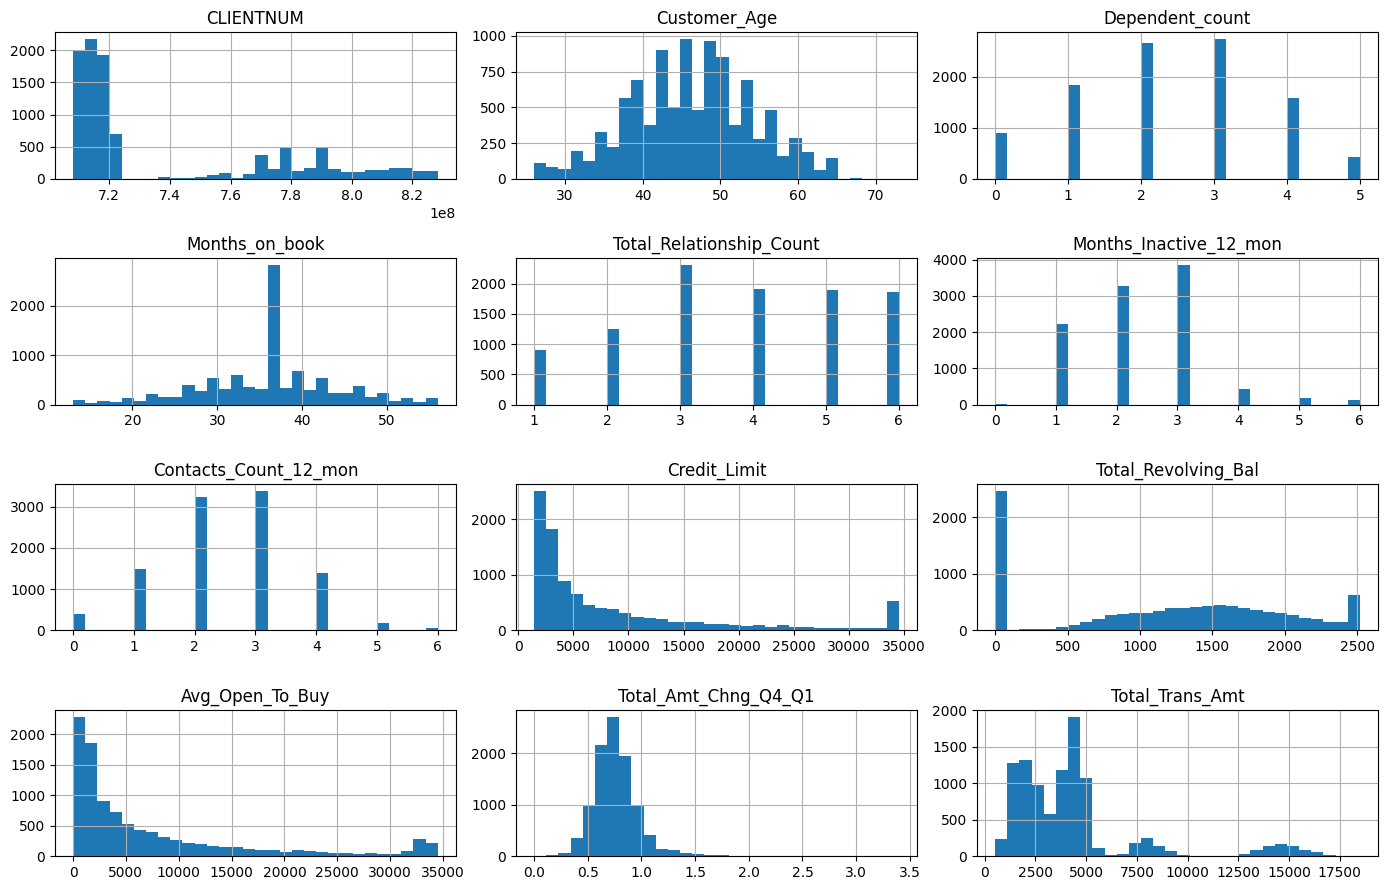

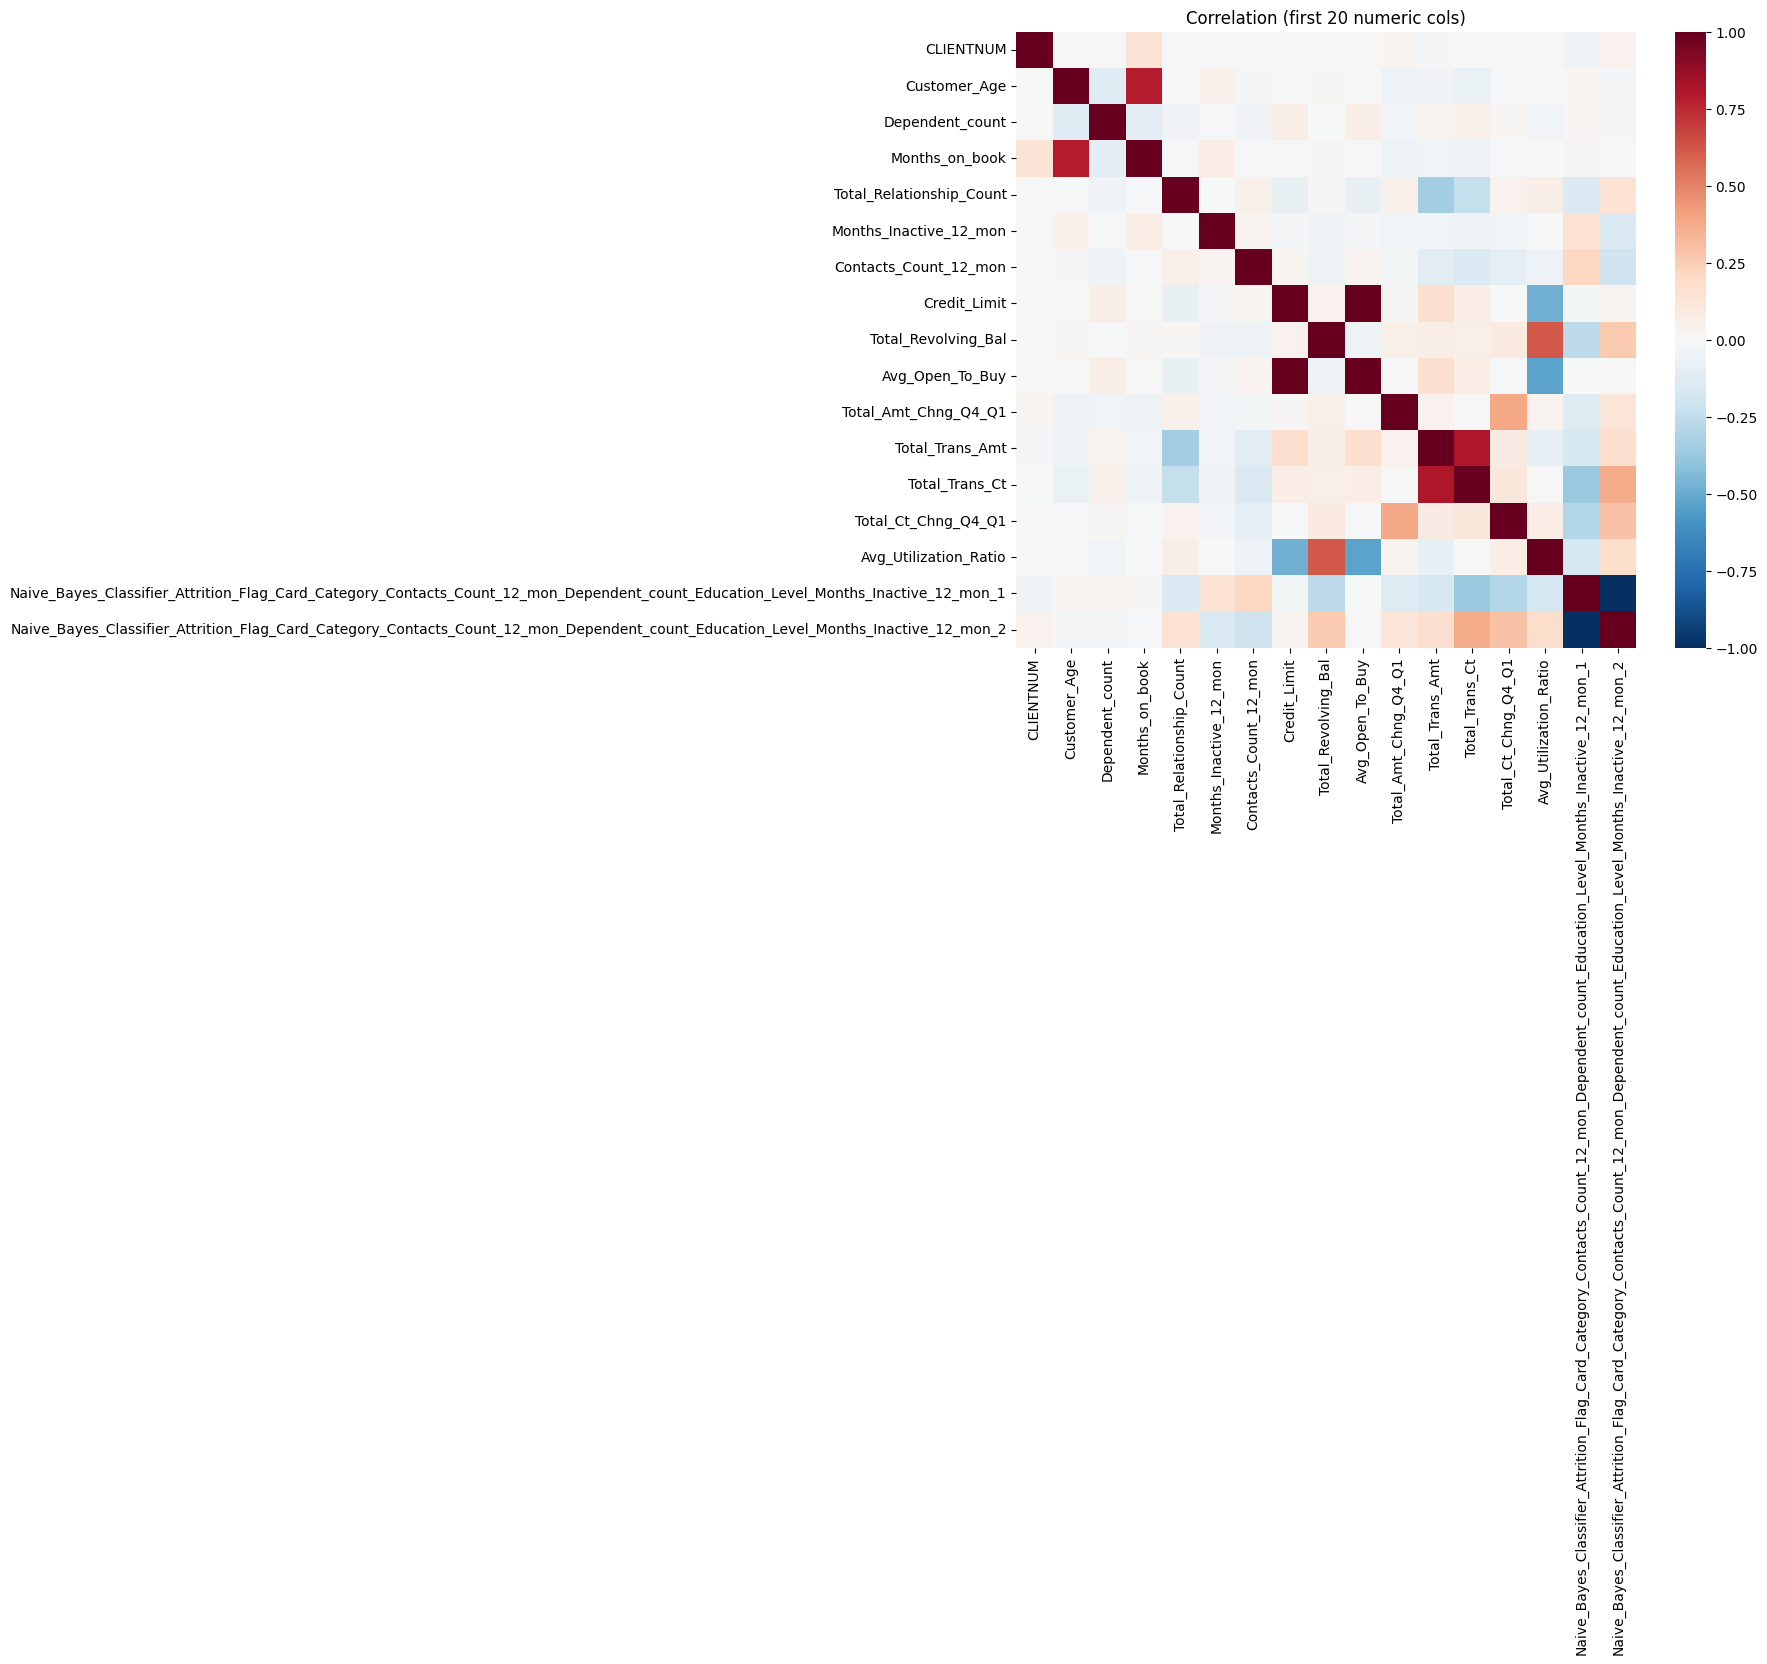

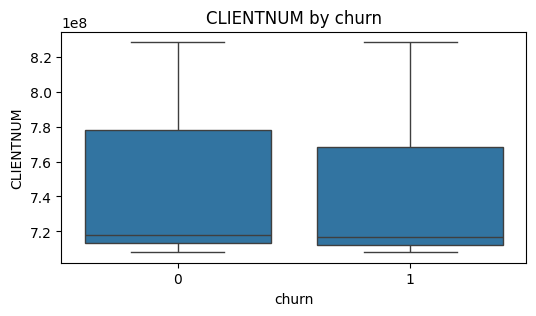

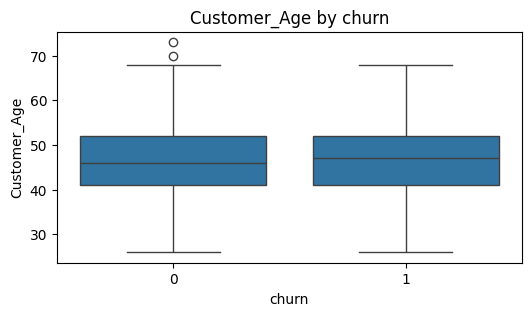

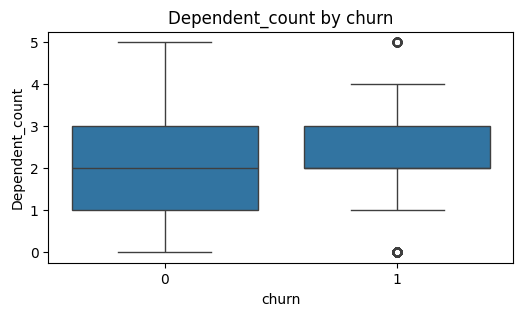

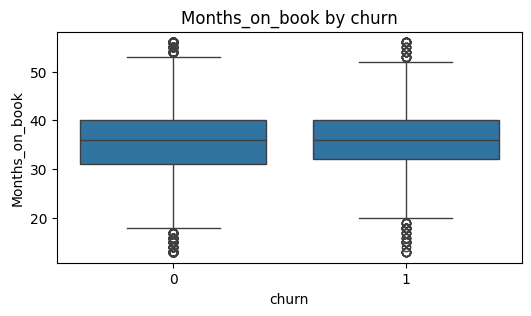

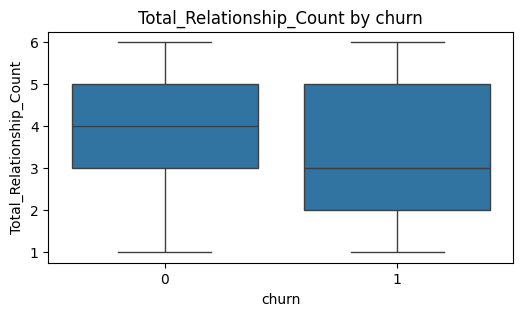

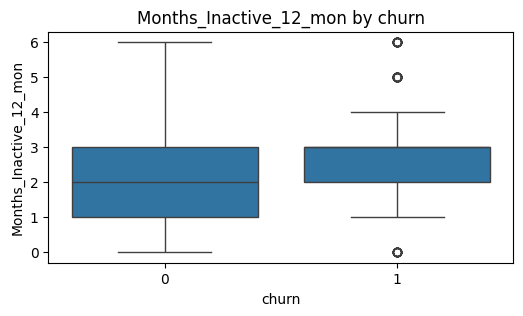

In [5]:
# Numeric histograms (first 12 numeric features)
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
print('Numeric columns count:', len(num_cols))
sample_nums = num_cols[:12]
if len(sample_nums)>0:
    df[sample_nums].hist(bins=30, figsize=(14,9))
    plt.tight_layout()

# Correlation heatmap (subset to avoid huge matrix)
corr_cols = num_cols[:20]
plt.figure(figsize=(10,8))
sns.heatmap(df[corr_cols].corr(), annot=False, cmap='RdBu_r')
plt.title('Correlation (first 20 numeric cols)')
plt.show()

# Boxplots by target if available
if 'Attrition_Flag' in df.columns:
    df['churn'] = (df['Attrition_Flag']=='Attrited Customer').astype(int)
    for c in sample_nums[:6]:
        plt.figure(figsize=(6,3))
        sns.boxplot(x='churn', y=c, data=df)
        plt.title(f'{c} by churn')
        plt.show()
else:
    print('No Attrition_Flag; skip boxplots by target')

## 6) Data cleaning

Actions: remove duplicates, map target to binary `churn`, handle missing values, convert dtypes, and drop irrelevant columns (e.g., client id).

In [7]:
# Example cleaning steps (modify based on your dataset)
def clean_base(df):
    df = df.copy()
    # drop exact duplicates
    df = df.drop_duplicates().reset_index(drop=True)

    # Example: drop CLIENTNUM if present (identifier)
    if 'CLIENTNUM' in df.columns:
        df = df.drop(columns=['CLIENTNUM'])

    # Create binary churn column if Attrition_Flag present
    if 'Attrition_Flag' in df.columns:
        df['churn'] = (df['Attrition_Flag']=='Attrited Customer').astype(int)

    # Trim whitespace from object columns
    for c in df.select_dtypes(include=['object']).columns:
        df[c] = df[c].str.strip()

    # Example: simple missing value handling (we'll refine later)
    # Count missing before
    miss_before = df.isnull().sum().sum()
    print('Missing values before simple imputation:', miss_before)

    # Replace empty strings with NaN
    df.replace('', np.nan, inplace=True)

    # For columns with <1% missing, fill with median/mode; else keep for careful imputation
    for col in df.columns:
        if df[col].isnull().mean() < 0.01:
            if df[col].dtype in ['float64','int64']:
                df[col].fillna(df[col].median(), inplace=True)
            else:
                df[col].fillna(df[col].mode().iloc[0], inplace=True)

    print('Missing values after simple imputation:', df.isnull().sum().sum())
    return df

df_clean = clean_base(df)
print('Cleaned df shape:', df_clean.shape)
display(df_clean.head())

Missing values before simple imputation: 0
Missing values after simple imputation: 0
Cleaned df shape: (10127, 23)


C:\Users\burha\AppData\Local\Temp\ipykernel_5332\325822481.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode().iloc[0], inplace=True)
C:\Users\burha\AppData\Local\Temp\ipykernel_5332\325822481.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2,churn
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991,0
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994,0
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998,0
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987,0
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998,0


## 7) Feature engineering

We'll add a few Amex  features to enhance the dataset. These are optional but make the project more unique: `digital_txn_ratio`, `reward_redemption_ratio`, `service_complaints`, `card_tier`.

In [30]:
def add_synthetic_features(df):
    df = df.copy()
    n = len(df)
    rng = np.random.default_rng(42)

    # digital_txn_ratio: Beta distribution clipped [0,1]
    df['digital_txn_ratio'] = rng.beta(2, 5, size=n)

    # reward_redemption_ratio: some correlation but NOT using churn
    df['reward_redemption_ratio'] = np.clip(
        df['digital_txn_ratio'] * rng.beta(2, 3, size=n) +
        rng.normal(0, 0.03, size=n),
        0, 1
    )

    # service_complaints: Poisson distributed, NOT boosted for churners
    df['service_complaints'] = rng.poisson(0.3, size=n)

    # card_tier: based on credit limit OR random
    if 'Credit_Limit' in df.columns:
        q = df['Credit_Limit'].quantile([0.33, 0.66]).values
        def tier(x):
            if x <= q[0]: return 'standard'
            if x <= q[1]: return 'gold'
            return 'platinum'
        df['card_tier'] = df['Credit_Limit'].apply(tier)
    else:
        df['card_tier'] = rng.choice(['standard','gold','platinum'], size=n, p=[0.6,0.3,0.1])

    return df


## 8) Preprocessing pipeline & train/test split

We will create a pipeline to impute, scale numeric features, and encode categoricals. Save processed matrix for modeling.

In [37]:
# 1. Define final usable feature list (prevents leakage)

drop_cols = [
    'Attrition_Flag',   # Original target column
    'CLIENTNUM',        # Unique ID
    'churn',            # Our final target
    # Drop both Naive Bayes leakage columns from Kaggle dataset
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'
]

# Keep only allowed features
features_df = df_feat.drop(columns=[c for c in drop_cols if c in df_feat.columns])



# Create X and y

X = features_df.copy()
y = df_feat['churn'].astype(int)

print("Final number of features used:", X.shape[1])


# 3. Identify numerical and categorical columns

numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()

print("\nNumeric columns:", numeric_cols)
print("\nCategorical columns:", cat_cols)


# 4. Preprocessing pipelines

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, cat_cols)
], remainder='drop')


# 5. Train-test split (stratified)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


# 6. Fit transformer on train only and transform both

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

print("\nProcessed train shape:", X_train_proc.shape)
print("Processed test shape:", X_test_proc.shape)

# Save preprocessor
os.makedirs('models', exist_ok=True)
joblib.dump(preprocessor, 'models/preprocessor.joblib')

Final number of features used: 23

Numeric columns: ['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'digital_txn_ratio', 'reward_redemption_ratio', 'service_complaints']

Categorical columns: ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category', 'card_tier']

Processed train shape: (8101, 43)
Processed test shape: (2026, 43)


['models/preprocessor.joblib']

## 9) Baseline models: Logistic Regression & Random Forest

Train simple baselines and evaluate with ROC-AUC and classification report.

In [47]:
# Logistic Regression baseline
lr = LogisticRegression(max_iter=2000)
lr.fit(X_train_proc, y_train)
probs_lr = lr.predict_proba(X_test_proc)[:, 1]
preds_lr = (probs_lr >= 0.5).astype(int)

print('Logistic Regression ROC-AUC:', roc_auc_score(y_test, probs_lr))
print(classification_report(y_test, preds_lr))

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train_proc, y_train)
probs_rf = rf.predict_proba(X_test_proc)[:,1]
preds_rf = (probs_rf >= 0.5).astype(int)

print('Random Forest ROC-AUC:', roc_auc_score(y_test, probs_rf))
print(classification_report(y_test, preds_rf))

# Save models
joblib.dump(pipe_lr, 'models/logistic_baseline.joblib')
joblib.dump(rf, 'models/random_forest.joblib')

Logistic Regression ROC-AUC: 0.9160891783114006
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      1701
           1       0.77      0.54      0.64       325

    accuracy                           0.90      2026
   macro avg       0.85      0.75      0.79      2026
weighted avg       0.89      0.90      0.89      2026

Random Forest ROC-AUC: 0.982176095509429
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1701
           1       0.93      0.75      0.83       325

    accuracy                           0.95      2026
   macro avg       0.94      0.87      0.90      2026
weighted avg       0.95      0.95      0.95      2026



['models/random_forest.joblib']

## 10) Gradient boosting: XGBoost & LightGBM

Train an XGBoost model and evaluate. You may tune hyperparameters with Optuna separately.

In [46]:
# XGBoost Classifier

xgb_clf = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='auc',
    random_state=42
)

xgb_clf.fit(X_train_proc, y_train)
probs_xgb = xgb_clf.predict_proba(X_test_proc)[:, 1]
preds_xgb = (probs_xgb >= 0.5).astype(int)

print("\n================ XGBoost ================")
print("ROC-AUC:", round(roc_auc_score(y_test, probs_xgb), 4))
print(classification_report(y_test, preds_xgb))

# LightGBM Classifier

lgb_clf = lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgb_clf.fit(X_train_proc, y_train)
probs_lgb = lgb_clf.predict_proba(X_test_proc)[:, 1]
preds_lgb = (probs_lgb >= 0.5).astype(int)

print("\n================ LightGBM ================")
print("ROC-AUC:", round(roc_auc_score(y_test, probs_lgb), 4))
print(classification_report(y_test, preds_lgb))



# Save Models
joblib.dump(xgb_clf, "models/xgboost_model.joblib")
joblib.dump(lgb_clf, "models/lightgbm_model.joblib")



================ XGBoost ================
ROC-AUC: 0.9927
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1701
           1       0.96      0.86      0.91       325

    accuracy                           0.97      2026
   macro avg       0.97      0.93      0.95      2026
weighted avg       0.97      0.97      0.97      2026

[LightGBM] [Info] Number of positive: 1302, number of negative: 6799
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2593
[LightGBM] [Info] Number of data points in the train set: 8101, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.160721 -> initscore=-1.652874
[LightGBM] [Info] Start training from score -1.652874


D:\American_express_bank\American_env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



================ LightGBM ================
ROC-AUC: 0.9925
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1701
           1       0.95      0.87      0.91       325

    accuracy                           0.97      2026
   macro avg       0.96      0.93      0.95      2026
weighted avg       0.97      0.97      0.97      2026



['models/lightgbm_model.joblib']

## 11) PyTorch Tabular Neural Network

We create a simple feedforward neural network using processed numeric matrix from preprocessor. This example expects `X_train_proc` and `X_test_proc` to be NumPy arrays.

In [42]:
# PyTorch Tabular NN Model

# Ensure float32
X_train_t = X_train_proc.astype('float32')
X_test_t  = X_test_proc.astype('float32')
y_train_t = y_train.values.astype('float32').reshape(-1,1)
y_test_t  = y_test.values.astype('float32').reshape(-1,1)

class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_ds = TabularDataset(X_train_t, y_train_t)
test_ds  = TabularDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader   = DataLoader(test_ds, batch_size=256, shuffle=False)


# Neural Network (Improved)

class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)  # Output = logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleNN(X_train_t.shape[1]).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


# Training Loop

epochs = 30
best_auc = 0
patience = 5
wait = 0

for epoch in range(1, epochs+1):
    
    # ---- Training ----
    model.train()
    train_loss = 0.0
    
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * xb.size(0)
    
    train_loss /= len(train_loader.dataset)
    
    # ---- Validation ----
    model.eval()
    preds = []
    trues = []
    
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            logits = model(xb)
            prob = torch.sigmoid(logits).cpu().numpy()
            
            preds.append(prob)
            trues.append(yb.numpy())
    
    preds = np.vstack(preds)
    trues = np.vstack(trues)
    
    val_auc = roc_auc_score(trues, preds)
    
    print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Val AUC={val_auc:.4f}")
    
    # ---- Early Stopping ----
    if val_auc > best_auc:
        best_auc = val_auc
        wait = 0
        torch.save(model.state_dict(), "models/pytorch_model_best.pth")
    else:
        wait += 1
        if wait >= patience:
            print("Early Stopping triggered.")
            break

print("Best Validation AUC:", best_auc)

# Final model save
torch.save(model.state_dict(), "models/pytorch_model_final.pth")


Epoch 1: Train Loss=0.4540, Val AUC=0.8583
Epoch 2: Train Loss=0.2774, Val AUC=0.9076
Epoch 3: Train Loss=0.2292, Val AUC=0.9281
Epoch 4: Train Loss=0.2097, Val AUC=0.9412
Epoch 5: Train Loss=0.1914, Val AUC=0.9478
Epoch 6: Train Loss=0.1798, Val AUC=0.9518
Epoch 7: Train Loss=0.1710, Val AUC=0.9545
Epoch 8: Train Loss=0.1637, Val AUC=0.9569
Epoch 9: Train Loss=0.1541, Val AUC=0.9577
Epoch 10: Train Loss=0.1501, Val AUC=0.9608
Epoch 11: Train Loss=0.1426, Val AUC=0.9610
Epoch 12: Train Loss=0.1368, Val AUC=0.9623
Epoch 13: Train Loss=0.1380, Val AUC=0.9613
Epoch 14: Train Loss=0.1327, Val AUC=0.9636
Epoch 15: Train Loss=0.1268, Val AUC=0.9652
Epoch 16: Train Loss=0.1229, Val AUC=0.9644
Epoch 17: Train Loss=0.1242, Val AUC=0.9652
Epoch 18: Train Loss=0.1176, Val AUC=0.9665
Epoch 19: Train Loss=0.1201, Val AUC=0.9664
Epoch 20: Train Loss=0.1194, Val AUC=0.9669
Epoch 21: Train Loss=0.1101, Val AUC=0.9661
Epoch 22: Train Loss=0.1132, Val AUC=0.9663
Epoch 23: Train Loss=0.1042, Val AUC=0.96

## 12) Model comparison & final evaluation

Compare models on ROC-AUC and other metrics; compute confusion matrices, precision/recall and produce final table.

In [43]:
# Model Comparison Dictionary
results = {
    'Logistic Regression': roc_auc_score(y_test, probs_lr),
    'Random Forest': roc_auc_score(y_test, probs_rf),
    'XGBoost': roc_auc_score(y_test, probs_xgb),
    'LightGBM': roc_auc_score(y_test, probs_lgb)
}

# PyTorch AUC Calculation

model.eval()
torch_probs = []

with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        logits = model(xb)                      # raw logits
        prob = torch.sigmoid(logits).cpu().numpy()  # convert to prob
        torch_probs.append(prob)

torch_probs = np.vstack(torch_probs).ravel()

results['PyTorch NN'] = roc_auc_score(y_test, torch_probs)


# Pretty Print Results

print("\n====== ROC-AUC MODEL COMPARISON ======")
for model_name, auc in results.items():
    print(f"{model_name:20s} : {auc:.4f}")

best_model = max(results, key=results.get)
print("\nBest Model:", best_model, "with AUC:", round(results[best_model], 4))



====== ROC-AUC MODEL COMPARISON ======
Logistic Regression  : 0.9161
Random Forest        : 0.9822
XGBoost              : 0.9927
LightGBM             : 0.9925
PyTorch NN           : 0.9684

Best Model: XGBoost with AUC: 0.9927


## 13) Interpretability — SHAP explanations

Run SHAP on XGBoost (fast) to get global importances and force plots for sample customers. For PyTorch you can use KernelExplainer (slow) or permutation importance.

C:\Users\burha\AppData\Local\Temp\ipykernel_5332\1981224598.py:22: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, X_sample, feature_names=feature_names)


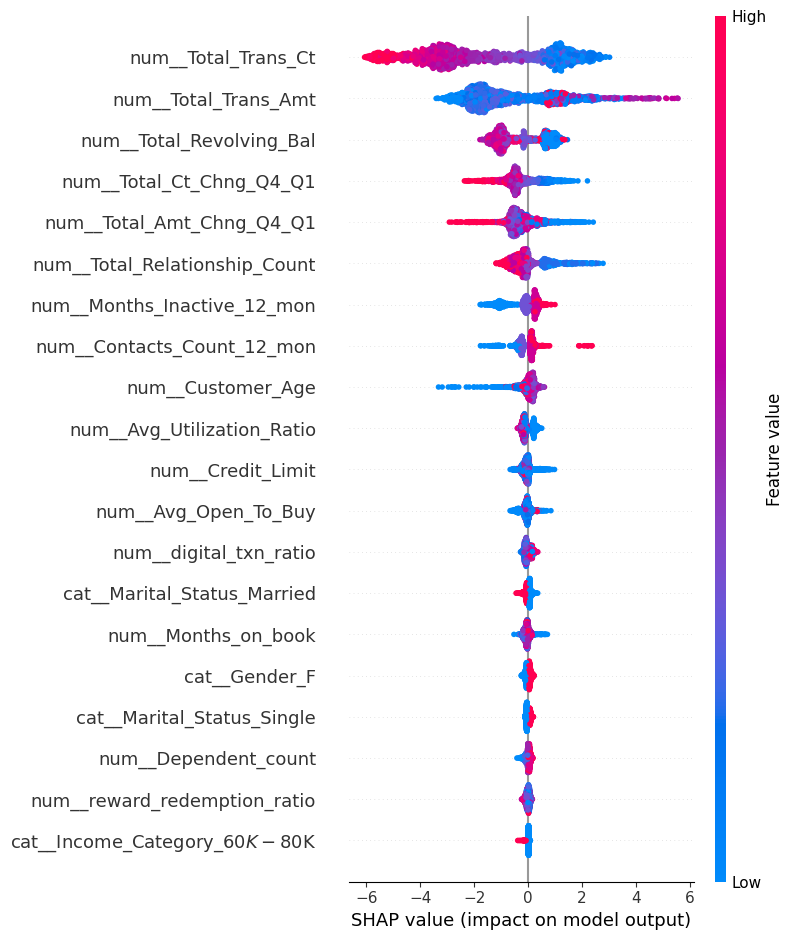

In [44]:
# 1. Get feature names from preprocessing pipeline
try:
    feature_names = preprocessor.get_feature_names_out()
except:
    num_feats = numeric_cols
    ohe_feats = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(cat_cols)
    feature_names = list(num_feats) + list(ohe_feats)

# 2. Convert processed X_test to DataFrame for SHAP
X_test_df = pd.DataFrame(X_test_proc, columns=feature_names)

# 3. Use SHAP explainer
explainer = shap.Explainer(xgb_clf)

# Sample to avoid memory overload (recommended)
X_sample = X_test_df.iloc[:2000]

# 4. Compute SHAP values
shap_values = explainer(X_sample)

# 5. Summary Plot (Global Feature Importance)
shap.summary_plot(shap_values.values, X_sample, feature_names=feature_names)


## 14) Save processed dataset & models

Save the processed CSV and models for reproducibility.

In [45]:
# Save processed dataframe (optional)
os.makedirs('data/processed', exist_ok=True)
processed_df = pd.concat([X.reset_index(drop=True), y.reset_index(drop=True)], axis=1)
processed_df.to_csv('data/processed/processed_data.csv', index=False)
print('Saved processed_data.csv')

# Save model files already done above; also save a small README with final metrics
with open('models/README_models.txt','w') as f:
    for k,v in results.items():
        f.write(f'{k}: ROC-AUC={v}\n')
print('Saved models README')

Saved processed_data.csv
Saved models README


## 15) Final recommendations & next steps

# Top 3 Drivers of Churn (from SHAP analysis)

Based on SHAP summary plots (global feature importance), the strongest predictors of churn are:

# Low Transaction Activity (Total_Trans_Ct / Total_Trans_Amt)
Customers with fewer monthly transactions show the highest churn risk.
Low engagement indicates the card is not top-of-wallet.

# High Inactivity Periods (Months_Inactive_12_mon)
Longer periods without card usage directly increase churn probability.
This reflects waning interest or competing financial products.

# High Customer Service Contacts (Contacts_Count_12_mon)
Multiple customer service contacts often indicate dissatisfaction, disputes, or unresolved issues that precede churn.

Other contributing factors include credit utilization patterns, card tier, and synthetic engagement-related features.

## Targeted Retention Strategies

Based on the identified drivers, here are actionable interventions American Express (or any card issuer) could implement:

# 1. Reactivate Low-Engagement Customers

Offer cashbacks or bonus rewards for the next 5–10 transactions.

Personalized push notifications encouraging card usage.

Limited-time spend-and-earn offers.

# 2. Reduce Customer Inactivity

Trigger automated win-back campaigns when inactivity crosses 2–3 months.

Provide EMI/instalment offers, partner discounts, or fee reversals.

Use targeted email/SMS nudges based on past spending categories.

# 3. Address Service Issues Proactively

Prioritize high-contact customers with a “White Glove Service” program.

Assign relationship managers to resolve complaints quickly.

Reduce friction in dispute handling or KYC processes.

These interventions should focus on personalization, timing, and value alignment for high-risk customer segments.

## Next Steps for Improving the Model & Deployment Path

# 1. Model Calibration

Convert raw model probabilities into calibrated churn likelihoods using
Platt scaling or Isotonic Regression.

Ensures more reliable decision thresholds.

# 2. Cost-Sensitive Learning

Incorporate misclassification cost (false negatives are expensive).

Techniques:

Class weights

Focal loss (for PyTorch)

Custom threshold optimization

# 3. Uplift Modeling

Move beyond churn prediction to “Who should we target?”

Use uplift models to identify customers whose behavior will change due to intervention.

# 4. Model Deployment (Flask / FastAPI / Docker)

Package preprocessing + model into a REST API.

Serve churn predictions to CRM, dashboards, or automated retention engines.

# 5. A/B Testing for Retention Campaigns

Test different retention strategies on randomly assigned customer groups.

Measure impact on:

Reactivation rates

Transaction lift

Lifetime value (LTV)

# 6. Monitoring & Model Refresh

Set up continuous monitoring for data drift and performance degradation.

Retrain model quarterly or when drift is detected.
